## Testbed for GLMs
Using an unpublished S1 dataset

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD']



In [4]:
import scipy.io
math = scipy.io.loadmat('s1_ari_proc.mat')

### 1.1 Covariates

In [5]:
data = pd.DataFrame()
data['time'] =  math['time'][0]
data['handPos_x'] =  math['handPos'][0] - np.mean(math['handPos'][0])
data['handPos_y'] =  math['handPos'][1] - np.mean(math['handPos'][1])
data['handVel_x'] =  math['handVel'][0]
data['handVel_y'] =  math['handVel'][1]
data['handAcc_x'] =  math['handAcc'][0]
data['handAcc_y'] =  math['handAcc'][1]
data.head() 

,time,handPos_x,handPos_y,handVel_x,handVel_y,handAcc_x,handAcc_y
0,1.17,-0.161031,0.874437,0.151037,0.150912,0.495429,0.545026
1,1.22,-0.160162,0.881708,-0.139498,0.110064,-4.584201,-5.705682
2,1.27,-0.172404,0.874037,-0.355774,-0.396433,-2.825068,-2.918046
3,1.32,-0.188853,0.856217,-0.243297,-0.276727,4.535535,6.446413
4,1.37,-0.194168,0.857506,0.026628,0.287959,0.261249,-0.374490


In [6]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LabelKFold


def poisson_pseudoR2(y, yhat, ynull):
    yhat = yhat.reshape(y.shape)
    
    eps = np.spacing(1)
    L1 = np.sum(y*np.log(eps+yhat) - yhat)
    L1_v = y*np.log(eps+yhat) - yhat
    L0 = np.sum(y*np.log(eps+ynull) - ynull)
    LS = np.sum(y*np.log(eps+y) - y)
    R2 = 1-(LS-L1)/(LS-L0)
    return R2

def fit_cv(X, Y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=1, label=[],func=None):

    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))

    if len(label)>0:
        skf  = LabelKFold(np.squeeze(label), n_folds=n_cv)
    else:
        skf  = KFold(n=np.size(Y), n_folds=n_cv, shuffle=True, random_state=42)

    i=1
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        if verbose > 1:
            print( '...runnning cv-fold', i, 'of', n_cv)
        i+=1
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]

        if func:
            Yt_hat = func(Xr, Yr, Xt)
        else:
            Yt_hat = eval(algorithm)(Xr, Yr, Xt)
        Y_hat[idx_t] = Yt_hat

        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

        if verbose > 1:
            print( 'pR2: ', pR2)

    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                             np.std(pR2_cv)/np.sqrt(n_cv)))
        #print("Mean y: "+str(np.mean(Y))+", mean yhat: "+str(np.mean(Y_hat)))
        

    
    return Y_hat, pR2_cv


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### compute more covariates/features

In [7]:
data['velDir'] = np.arctan2(data['handVel_y'], data['handVel_x'])
data['cos_velDir'] = np.cos(data['velDir'])
data['sin_velDir'] = np.sin(data['velDir'])
data['speed'] = np.sqrt(data['handVel_x'].values**2+data['handVel_y'].values**2)
r = np.arctan2(data['handPos_y'], data['handPos_x'])
data['PosDir'] = r
data['cos_PosDir'] = np.cos(r)
data['sin_PosDir'] = np.sin(r)
data['radial_Pos'] = np.sqrt(data['handPos_x'].values**2+data['handPos_y'].values**2)
data.head()

,time,handPos_x,handPos_y,handVel_x,handVel_y,handAcc_x,handAcc_y,velDir,cos_velDir,sin_velDir,speed,PosDir,cos_PosDir,sin_PosDir,radial_Pos
0,1.17,-0.161031,0.874437,0.151037,0.150912,0.495429,0.545026,0.784984,0.707399,0.706814,0.213511,1.752910,-0.181109,0.983463,0.889141
1,1.22,-0.160162,0.881708,-0.139498,0.110064,-4.584201,-5.705682,2.473595,-0.785063,0.619415,0.177691,1.750487,-0.178725,0.983899,0.896137
2,1.27,-0.172404,0.874037,-0.355774,-0.396433,-2.825068,-2.918046,-2.302194,-0.667911,-0.744241,0.532667,1.765546,-0.193521,0.981096,0.890878
3,1.32,-0.188853,0.856217,-0.243297,-0.276727,4.535535,6.446413,-2.291999,-0.660288,-0.751012,0.368471,1.787887,-0.215389,0.976528,0.876797
4,1.37,-0.194168,0.857506,0.026628,0.287959,0.261249,-0.374490,1.478586,0.092079,0.995752,0.289188,1.793474,-0.220842,0.975310,0.879214


### 1.2 Neural data
#### Choose neuron

In [8]:
neuron_n = 1
y = math['spikes'][neuron_n-1]

#### check for position direction tuning and radial distance tuning

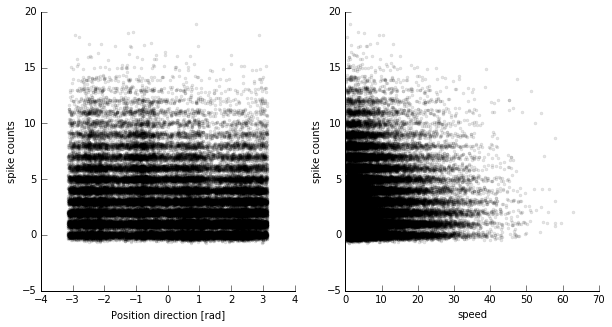

In [9]:
plt.figure(figsize=(10,5))

y_noise = np.random.randn(np.size(y))
nnoise = 0.2

plt.subplot(121)
simpleaxis(plt.gca())

plt.plot(data['PosDir'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('Position direction [rad]')
plt.ylabel('spike counts')

plt.subplot(122)
simpleaxis(plt.gca())

plt.plot(data['speed'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('speed')
plt.ylabel('spike counts')

plt.show()

Show the smoothed data, and the smoothed prediction, for each feature of interest.

In [10]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess


def plot_smoothed(features,y,Ythat):
    """Features is list of strings of feature names (in dataframe)"""
    l = len(features)
    plt.figure(figsize=(5*l,5))
    for i in range(l):
        plt.subplot(1,l,i+1)
        simpleaxis(plt.gca())
        feat = data[features[i]]
        delt = 0.001*(np.max(feat)-np.min(feat))
        plt.plot(feat, y+nnoise*y_noise, 'k.', alpha=0.1)
        plt.xlabel(features[i])
        plt.ylabel('spike counts')
        
        
        #smooth data
        smoothed = lowess(y,feat,return_sorted=True,frac=.05,delta = delt)
        plt.plot(smoothed[:,0],smoothed[:,1],color=colors[0],lw = 3)
        
        #smooth fit
        smoothed = lowess(Ythat,feat,return_sorted=True,frac=.05,delta=delt)
        plt.plot(smoothed[:,0],smoothed[:,1],color=colors[1],lw = 3)
    plt.tight_layout()
    plt.show()

        
        

# 2. GLM with poisson output

### using [pyglmnet](https://github.com/pavanramkumar/pyglmnet)
this is a python implementation of R's glmnet package

In [11]:
from pyglmnet import GLM

the firing rate is not linear on the movement angle, we need to do some feature engineering. More details [here](https://github.com/KordingLab/spykes/blob/master/notebooks_documentation/gradient_descent_tutorial.ipynb).

## Test GLM regularization

Why is it working so terribly? First let's look at the the pyglmnet implementation. (also: bayesian optimzation of a GLM in keras, later).

Test, neuron 8, a high firing, and neuron 15, a low firing

In [12]:
X_ = data.drop(['time','velDir','PosDir','handPos_x','handPos_y','handVel_x','handVel_y'], axis=1)
#X_ = data[['handPos_x','handPos_y','handVel_x','handVel_y']]

X_.head()

,handAcc_x,handAcc_y,cos_velDir,sin_velDir,speed,cos_PosDir,sin_PosDir,radial_Pos
0,0.495429,0.545026,0.707399,0.706814,0.213511,-0.181109,0.983463,0.889141
1,-4.584201,-5.705682,-0.785063,0.619415,0.177691,-0.178725,0.983899,0.896137
2,-2.825068,-2.918046,-0.667911,-0.744241,0.532667,-0.193521,0.981096,0.890878
3,4.535535,6.446413,-0.660288,-0.751012,0.368471,-0.215389,0.976528,0.876797
4,0.261249,-0.374490,0.092079,0.995752,0.289188,-0.220842,0.975310,0.879214


In [14]:
X = X_.values

## wtf
#X = np.ones((len(y),))

neuron_n = 8
y = math['spikes'][neuron_n]


# reg lambda = None defaults to path from 0.5 to 0.01
rl = None
rl = np.logspace(np.log(5), np.log(0.001), 10,base=np.exp(1))


def glm_pyglmnet(Xr, Yr, Xt):
    glm = GLM(distr='poisson', alpha=0.1, reg_lambda=None, tol=1e-6, solver='cdfast',
     #  learning_rate=0.01, max_iter=10000, eta=4.0, random_state=1, verbose=False,
            )# score_metric = 'pseudo_R2')
    glm.fit(Xr, Yr)
    Yt = glm.predict(Xt)[0]
    
    print("\nMean y_test: "+str(np.mean(Yr))+"\n GLM thinks mean y: "+str(np.mean(glm.ynull_))+
      "\n exp(beta0) is "+str(np.exp(glm.fit_[0]['beta0'][0]))+"\n mean yhat is "+str(np.mean(Yt))+"\n" )

    return Yt

Yt_hat, PR2 = fit_cv(X, y, 'glm_pyglmnet', n_cv=4, verbose=2, label=[])


...runnning cv-fold 1 of 4

Mean y_test: 0.885599391371
 GLM thinks mean y: 0.885599391371
 exp(beta0) is 0.0540917950163
 mean yhat is 0.0540917950163

pR2:  -2.19515737482
...runnning cv-fold 2 of 4

Mean y_test: 0.879860884686
 GLM thinks mean y: 0.879860884686
 exp(beta0) is nan
 mean yhat is nan

pR2:  nan
...runnning cv-fold 3 of 4

Mean y_test: 0.875361373764
 GLM thinks mean y: 0.875361373764
 exp(beta0) is 0.0363353023646
 mean yhat is 0.0363353023646

pR2:  -2.74446251
...runnning cv-fold 4 of 4

Mean y_test: 0.876035213564
 GLM thinks mean y: 0.876035213564
 exp(beta0) is nan
 mean yhat is nan

pR2:  nan
pR2_cv: nan (+/- nan)


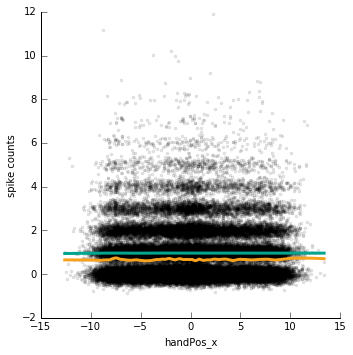

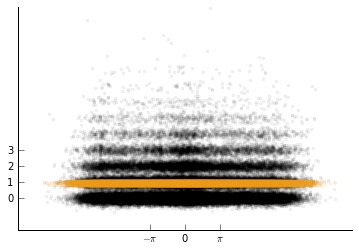

In [35]:
plot_smoothed(['handPos_x'],y,Yt_hat)

f= plt.figure()
ax2 = plt.gca()
plt.plot(data['handPos_x'], y+nnoise*y_noise, 'k.', alpha=0.05)
plt.plot(data['handPos_x'], Yt_hat, '.', c=colors[0], alpha=0.1)
ax2.set_xticks([-np.pi,0,np.pi])
ax2.set_yticks([0,1,2,3])
ax2.set_xticklabels(['$-\pi$','0','$\pi$'])
simpleaxis(plt.gca())

### Trying R's pyglmnet

In [36]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as n2r
n2r.activate()

r = ro.r
r.library('glmnet')

def r_glmnet_cv(Xr,Yr,Xt):
    yr = ro.FloatVector(Yr) # use factors
    trained_model = r['cv.glmnet'](Xr, yr, family="poisson",nfolds=5)
    lambda_min = np.asanyarray(trained_model.rx2('lambda.min'))[0]
    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
    return np.array(list(Yt))

def r_glmnet(Xr,Yr,Xt):
    yr = ro.FloatVector(Yr) # use factors
    trained_model = r['glmnet'](Xr, yr, family="poisson",alpha = 0.1)
    lambda_min = np.asanyarray(trained_model.rx2('lambda'))[-1]
    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
    return np.array(list(Yt))

In [43]:
X = X_.values

neuron_n = 14
y = math['spikes'][neuron_n]

Yt_hat, PR2 = fit_cv(X, y, 'r_glmnet', n_cv=4, verbose=2, label=[])


...runnning cv-fold 1 of 4
pR2:  0.0183773821172
...runnning cv-fold 2 of 4
pR2:  0.0233425437119
...runnning cv-fold 3 of 4
pR2:  0.0264237409177
...runnning cv-fold 4 of 4
pR2:  0.0251221671617
pR2_cv: 0.023316 (+/- 0.001527)


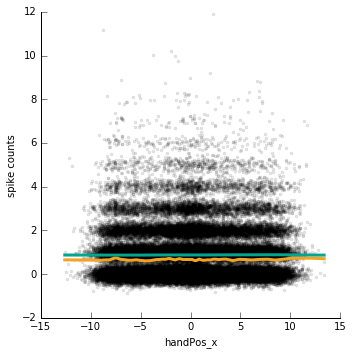

In [38]:
plot_smoothed(['handPos_x'],y,Yt_hat)

Seems to be working!! 

Let's try to run pyglmnet with the same regularization path...

In [44]:
neuron_n = 14
y = math['spikes'][neuron_n]
X = X_.values

def py_Rpath(Xr, Yr, Xt):
    #get path from glmnet
    yr = ro.FloatVector(Yr) 
    trained_model = r['glmnet'](Xr, yr, family="poisson",alpha = 0.1)
    path = np.asanyarray(trained_model.rx2('lambda'))
    
    #run with pyglmnet
    glm = GLM(distr='poisson', alpha=0.1, reg_lambda=path, tol=1e-4, solver='cdfast')
    glm.fit(Xr, Yr)
    Yt = glm.predict(Xt)[0]
    
    #print("\nMean y_test: "+str(np.mean(Yr))+"\n GLM thinks mean y: "+str(np.mean(glm.ynull_))+
    #  "\n exp(beta0) is "+str(np.exp(glm.fit_[0]['beta0'][0]))+"\n mean yhat is "+str(np.mean(Yt))+"\n" )

    return Yt

Yt_hat, PR2 = fit_cv(X, y, 'py_Rpath', n_cv=4, verbose=2, label=[])


...runnning cv-fold 1 of 4
pR2:  -3.94297086187
...runnning cv-fold 2 of 4
pR2:  -3.04011466963
...runnning cv-fold 3 of 4
pR2:  -10.6141983138
...runnning cv-fold 4 of 4
pR2:  -0.432698800984
pR2_cv: -4.507496 (+/- 1.876960)


#### What happens when we shuffle y?
Should be able to definitively show difference in behavior

In [47]:
y_shuff = np.random.permutation(y)

print('pyglmnet:\n')
Yt_hat, PR2 = fit_cv(X, y_shuff, 'glm_pyglmnet', n_cv=4, verbose=2, label=[])
print('\nRglmnet:\n')
Yt_hat, PR2 = fit_cv(X, y_shuff, 'r_glmnet', n_cv=4, verbose=2, label=[])
print('\npyglmnet with R`s path:\n')
Yt_hat, PR2 = fit_cv(X, y_shuff, 'py_Rpath', n_cv=4, verbose=2, label=[])

pyglmnet:

...runnning cv-fold 1 of 4

Mean y_test: 0.881904140854
 GLM thinks mean y: 0.881904140854
 exp(beta0) is 4.43550437788e-107
 mean yhat is 954.713530127

pR2:  -1353.59860856
...runnning cv-fold 2 of 4

Mean y_test: 0.879643517009
 GLM thinks mean y: 0.879643517009
 exp(beta0) is 6.54263785181e-107
 mean yhat is 909.013183652

pR2:  -1292.97752979
...runnning cv-fold 3 of 4

Mean y_test: 0.878208890338
 GLM thinks mean y: 0.878208890338
 exp(beta0) is 4.0609354102e-107
 mean yhat is 963.799902792

pR2:  -1359.04865823
...runnning cv-fold 4 of 4

Mean y_test: 0.877100315183
 GLM thinks mean y: 0.877100315183
 exp(beta0) is 3.22517928104e-107
 mean yhat is 916.400690361

pR2:  -1285.39234699
pR2_cv: -1322.754286 (+/- 16.865689)

Rglmnet:

...runnning cv-fold 1 of 4
pR2:  0.000159859779743
...runnning cv-fold 2 of 4
pR2:  -0.000217171529417
...runnning cv-fold 3 of 4
pR2:  -0.000661998145972
...runnning cv-fold 4 of 4
pR2:  -0.00026164006577
pR2_cv: -0.000245 (+/- 0.000146)

py

#### first define some functions

## Get GLM scores for all neurons with R glmnet.

Note: not part of pyglmnet diagnosis from here on down.

Use both sets of features, figure out which is better:

In [127]:
X = data[['handPos_x','handPos_y','handVel_x','handVel_y']].values
start = 0


if not start:
    Models = dict()
    Models['glm_all_pop'] = dict()
    Models['glm_all_pop']['PR2']  = list()
    Models['glm_all_pop']['Yt_hat']  = list()
    Models['glm_all_pop_2'] = dict()
    Models['glm_all_pop_2']['PR2']  = list()
    Models['glm_all_pop_2']['Yt_hat']  = list()

nneurons = np.shape(math['spikes'])[0]
for i in range(start,nneurons):
    print('\n running for neuron %d' % i)
    y = math['spikes'][i]

    Yt_hat, PR2 = fit_cv(X, y, algorithm = 'r_glmnet', n_cv=8, verbose=1, label=[])

    try:
        Models['glm_all_pop']['PR2'][i]=PR2
        Models['glm_all_pop']['Yt_hat'][i]=Yt_hat
    except IndexError:
        Models['glm_all_pop']['PR2'].append(PR2)
        Models['glm_all_pop']['Yt_hat'].append(Yt_hat)
        
        
X = data.drop(['time','velDir','PosDir','handPos_x','handPos_y','handVel_x','handVel_y'], axis=1).values
for i in range(start,nneurons):
    print('\n running for neuron %d' % i)
    y = math['spikes'][i]

    Yt_hat, PR2 = fit_cv(X, y, algorithm = 'r_glmnet', n_cv=8, verbose=1, label=[])

    try:
        Models['glm_all_pop_2']['PR2'][i]=PR2
        Models['glm_all_pop_2']['Yt_hat'][i]=Yt_hat
    except IndexError:
        Models['glm_all_pop_2']['PR2'].append(PR2)
        Models['glm_all_pop_2']['Yt_hat'].append(Yt_hat)
        



 running for neuron 0
pR2_cv: 0.038025 (+/- 0.000951)

 running for neuron 1
pR2_cv: 0.011055 (+/- 0.001078)

 running for neuron 2
pR2_cv: -0.000034 (+/- 0.001690)

 running for neuron 3
pR2_cv: 0.002638 (+/- 0.000407)

 running for neuron 4
pR2_cv: 0.001772 (+/- 0.000411)

 running for neuron 5
pR2_cv: -0.000102 (+/- 0.001028)

 running for neuron 6
pR2_cv: 0.000901 (+/- 0.000229)

 running for neuron 7
pR2_cv: -0.000916 (+/- 0.001522)

 running for neuron 8
pR2_cv: 0.000735 (+/- 0.000229)

 running for neuron 9
pR2_cv: 0.007285 (+/- 0.000776)

 running for neuron 10
pR2_cv: 0.000664 (+/- 0.000216)

 running for neuron 11
pR2_cv: 0.003321 (+/- 0.000737)

 running for neuron 12
pR2_cv: -0.002113 (+/- 0.001510)

 running for neuron 13
pR2_cv: 0.000389 (+/- 0.000117)

 running for neuron 14
pR2_cv: 0.024490 (+/- 0.000964)

 running for neuron 15
pR2_cv: 0.000075 (+/- 0.001586)

 running for neuron 16
pR2_cv: 0.006917 (+/- 0.000561)

 running for neuron 17
pR2_cv: -0.000101 (+/- 0.00105

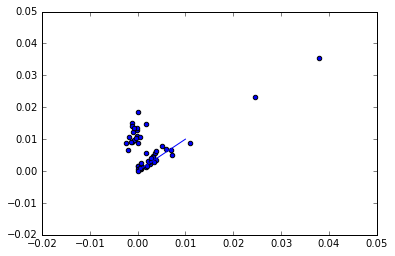

In [133]:
plt.scatter(np.mean(Models['glm_all_pop']['PR2'],axis=1),np.mean(Models['glm_all_pop_2']['PR2'],axis=1))
plt.plot([0,.01],[0,.01])

In [134]:
import pickle

with open('glm_s1.pickle', 'wb') as handle:
    pickle.dump(Models['glm_all_pop_2'], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Now do a GLM for hippocampus

In [5]:
math = scipy.io.loadmat('../data/hc_ari_proc.mat')

In [6]:
data = pd.DataFrame()
data['time'] =  math['time'][0]
data['x'] =  math['Xpos']
data['y'] =  math['Ypos']
data['vx'] =  math['Xvel']
data['vy'] =  math['Yvel']
data['angle'] =  math['Ang']

# or use:
#data['angle'] = data['velDir'] = np.arctan2(data['vx'], data['vy'])
spikes = pd.DataFrame(math['spikes'])
#drop nans
spikes = spikes.append(data['x']).append(data['vx']).dropna(axis=1, how='any').drop(['x','vx'])
data = data.dropna(axis=0, how='any')

print(data.shape, spikes.shape)
data.head() 

(110925, 6) (58, 110925)


,time,x,y,vx,vy,angle
552,27.625602,172.212693,54.724239,2.204274,-29.725750,-2.356680
553,27.675602,172.320990,53.537245,2.165926,-23.739884,-2.356748
554,27.725602,172.268949,52.538965,-1.040807,-19.965600,-2.332535
555,27.775602,172.120792,51.802308,-2.963155,-14.733130,-2.476142
556,27.825602,171.646395,51.102093,-9.487929,-14.004298,-1.775848


In [7]:
data['cos_velDir'] = np.cos(data['angle'])
data['sin_velDir'] = np.sin(data['angle'])
data['speed'] = np.sqrt(data['vx'].values**2+data['vy'].values**2)

In [8]:
# create 5x5 grid of means
xmax, xmin = data['x'].max(), data['x'].min()
ymax, ymin = data['y'].max(), data['y'].min()
xran = xmax-xmin
yran = ymax-ymin
dx = xran//5
dy = yran//5

yy,xx = np.mgrid[slice(ymin+dy/2, ymax-dy/2, dy),
                        slice(xmin+dx/2, xmax - dx/2, dx)]

#compute sig*(x(t)-mean) for all 25
logl = np.zeros((25,data['x'].shape[0]))
inv_sig = np.array([[1/(dx/2)**2, 0],[0, 1/(dy/2)**2]])
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        pos_offset = np.array([data['x']-xx[i,j],data['y']-yy[i,j]])
        # probably a better way to do this than list comp.
        l_ = ([-0.5*np.dot( np.dot(pos_offset[:,k],inv_sig), pos_offset[:,k]) 
                          for k in range(pos_offset.shape[1])])
        
        data['placeField_'+str(i)+'_'+str(j)]=l_

In [10]:
def r_glmnet_cv(Xr,Yr,Xt):
    yr = ro.FloatVector(Yr) # use factors
    trained_model = r['cv.glmnet'](Xr, yr, family="poisson",alpha=0.1,standardize=False,)
                               #    **{'lambda.min.ratio': 0.0001, 'upper.limits': 1e2, 'lower.limits': -1e2})
    lambda_min = np.asanyarray(trained_model.rx2('lambda.min'))[0]
    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
    return np.array(list(Yt))

def r_glmnet(Xr,Yr,Xt):
    yr = ro.FloatVector(Yr) # use factors
    trained_model = r['glmnet'](Xr, yr, family="poisson",alpha=0.4,standardize=True,
                                   **{'lambda.min.ratio': 0.0001})#, 'upper.limits': 1e2, 'lower.limits': -1e2})
    lambda_min = np.asanyarray(trained_model.rx2('lambda'))[-1]
    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
    return np.array(list(Yt))


In [11]:
X = data.drop(['x','y','vx', 'vy','time','angle'],axis=1).values
    
start = 0


if not start:
    hModels = dict()
    hModels['glm_all_pop'] = dict()
    hModels['glm_all_pop']['PR2']  = list()
    hModels['glm_all_pop']['Yt_hat']  = list()
    hModels['glm_all_pop_2'] = dict()
    hModels['glm_all_pop_2']['PR2']  = list()
    hModels['glm_all_pop_2']['Yt_hat']  = list()

nneurons = np.shape(math['spikes'])[0]
for i in range(start,nneurons):
    print('\n running for neuron %d' % i)
    y =  np.array(spikes.iloc[i,:])

    if np.mean(y)>1e-5:
        Yt_hat, PR2 = fit_cv(X, y, algorithm = 'r_glmnet_cv', n_cv=4, verbose=2, label=[])
    else:
        Yt_hat, PR2 = np.zeros(y.shape), np.array([0])

    try:
        hModels['glm_all_pop']['PR2'][i]=PR2
        hModels['glm_all_pop']['Yt_hat'][i]=Yt_hat
    except IndexError:
        hModels['glm_all_pop']['PR2'].append(PR2)
        hModels['glm_all_pop']['Yt_hat'].append(Yt_hat)



ValueError: labels ['x' 'y' 'vx' 'vy' 'angle'] not contained in axis

In [15]:
import pickle
with open('glm_hipp.pickle', 'wb') as handle:
    pickle.dump(hModels['glm_all_pop'], handle, protocol=pickle.HIGHEST_PROTOCOL)

### Rerun the Stevenson M1 dataset

In [5]:
math = scipy.io.loadmat('../data/4Hugo_new.mat')

In [6]:
data = pd.DataFrame()
data['time'] =  math['time'][0]
data['handPos_x'] =  math['handPos'][0]
data['handPos_y'] =  math['handPos'][1]
data['handVel_x'] =  math['handVel'][0]
data['handVel_y'] =  math['handVel'][1]
data['velDir'] = np.arctan2(data['handVel_y'], data['handVel_x'])
data['cos_velDir'] = np.cos(data['velDir'])
data['sin_velDir'] = np.sin(data['velDir'])
data['speed'] = np.sqrt(data['handVel_x'].values**2+data['handVel_y'].values**2)
r = np.arctan2(data['handPos_y'], data['handPos_x'])
data['cos_PosDir'] = np.cos(r)
data['sin_PosDir'] = np.sin(r)
data['radial_Pos'] = np.sqrt(data['handPos_x'].values**2+data['handPos_y'].values**2)
data.head()

,time,handPos_x,handPos_y,handVel_x,handVel_y,velDir,cos_velDir,sin_velDir,speed,cos_PosDir,sin_PosDir,radial_Pos
0,12.591,0.002905,-0.303636,-0.011201,-0.006237,-2.633523,-0.873685,-0.486491,0.012820,0.009568,-0.999954,0.303650
1,12.641,0.002260,-0.303869,-0.010743,-0.000833,-3.064245,-0.997010,-0.077271,0.010775,0.007437,-0.999972,0.303877
2,12.691,0.002399,-0.303631,0.017680,0.012094,0.599956,0.825360,0.564606,0.021420,0.007900,-0.999969,0.303641
3,12.741,0.004010,-0.302399,0.044667,0.038700,0.713933,0.755792,0.654812,0.059100,0.013258,-0.999912,0.302426
4,12.791,0.006386,-0.300673,0.042202,0.017021,0.383375,0.927408,0.374053,0.045505,0.021233,-0.999775,0.300741


In [13]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as n2r
n2r.activate()

r = ro.r
r.library('glmnet')

def r_glmnet_cv(Xr,Yr,Xt):
    yr = ro.FloatVector(Yr) # use factors
    trained_model = r['cv.glmnet'](Xr, yr, family="poisson",nfolds=5)
    lambda_min = np.asanyarray(trained_model.rx2('lambda.min'))[0]
    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
    return np.array(list(Yt))

def r_glmnet(Xr,Yr,Xt):
    yr = ro.FloatVector(Yr) # use factors
    trained_model = r['glmnet'](Xr, yr, family="poisson",alpha = 0.1)
    lambda_min = np.asanyarray(trained_model.rx2('lambda'))[-1]
    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
    return np.array(list(Yt))

In [24]:
start = 0

Xs = {'all': data.drop('time', axis=1).values,
      'angle': data[['cos_velDir','sin_velDir']].values,
      'dir' :  np.hstack((data[['velDir']].values,np.ones(data[['velDir']].values.shape))),
      'ori' : data[['handVel_x', 'handVel_x', 'handPos_x', 'handPos_y']].values }

mModels = dict()
for run in ['dir']:
    
    if not start:
        mModels['glm_'+run+'_pop'] = dict()
        mModels['glm_'+run+'_pop']['PR2']  = list()
        mModels['glm_'+run+'_pop']['Yt_hat']  = list()
    
    nneurons = np.shape(math['spikes'])[0]
    for i in range(start,nneurons-1):
        print('\n running for neuron %d' % i)
        X = Xs[run]
        y = math['spikes'][i]


        try:
            Yt_hat, PR2 = fit_cv(X, y, algorithm = 'r_glmnet', n_cv=4, verbose=1, label=[])
        except:
             Yt_hat, PR2 = np.zeros(y.shape), [0,0,0,0]
            
        try:
            mModels['glm_'+run+'_pop']['PR2'][i]=PR2
            mModels['glm_'+run+'_pop']['Yt_hat'][i]=Yt_hat
        except IndexError:
            mModels['glm_'+run+'_pop']['PR2'].append(PR2)
            mModels['glm_'+run+'_pop']['Yt_hat'].append(Yt_hat)


 running for neuron 0
pR2_cv: 0.006744 (+/- 0.000832)

 running for neuron 1
pR2_cv: 0.008525 (+/- 0.001781)

 running for neuron 2
pR2_cv: 0.010558 (+/- 0.001001)

 running for neuron 3
pR2_cv: 0.008568 (+/- 0.000559)

 running for neuron 4
pR2_cv: -0.000341 (+/- 0.000145)

 running for neuron 5
pR2_cv: -0.003068 (+/- 0.001326)

 running for neuron 6
pR2_cv: 0.001401 (+/- 0.000400)

 running for neuron 7
pR2_cv: -0.002015 (+/- 0.002758)

 running for neuron 8
pR2_cv: 0.000112 (+/- 0.000367)

 running for neuron 9
pR2_cv: 0.000099 (+/- 0.001784)

 running for neuron 10
pR2_cv: 0.002437 (+/- 0.000974)

 running for neuron 11
pR2_cv: -0.000620 (+/- 0.000464)

 running for neuron 12
pR2_cv: 0.000194 (+/- 0.000300)

 running for neuron 13

 running for neuron 14
pR2_cv: 0.000358 (+/- 0.000300)

 running for neuron 15
pR2_cv: 0.000073 (+/- 0.000152)

 running for neuron 16
pR2_cv: 0.002250 (+/- 0.000686)

 running for neuron 17

 running for neuron 18
pR2_cv: 0.000946 (+/- 0.000242)

 runn

In [25]:
import pickle
with open('glm_m1_dir.pickle', 'wb') as handle:
    pickle.dump(mModels['glm_dir_pop'], handle, protocol=2)

In [22]:
with open('glm_s1.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
with open('glm_s1.pickle', 'wb') as handle:
    pickle.dump(unserialized_data, handle, protocol=2)
    
with open('glm_hipp.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
with open('glm_hipp.pickle', 'wb') as handle:
    pickle.dump(unserialized_data, handle, protocol=2)